# Mobile sensing Lab 2 - Python framework for data processing - Part 1 (Data engineering)

We will develop a machine learning pipeline for activity recognition from smartphone sensor data (acceleration, gravity, etc.). The first part of the pipeline contains:

1. Exploratory data analysis - check data quality and calculate informative statistics about the dataset;
2. Segmentation and filtering - segment the data into windows (e.g., 4 seconds data) and try different filtering methods to improve the sensor data quality i.e., remove noise;

The second part of the pipeline contains:
3. Feature extraction and visualization - calculate features for each segment, which will be used as input to machine learning models;
4. Building and evaluation of machine learning models.

## 1. Import data and check data quality/validity

The dataset that we are going to use is downloaded form: https://github.com/mmalekzadeh/motion-sense.

The dataset includes raw data from 4 sensors, 3-axis per sensor, thus 4x3 = 12 time-series. More specifically, the sensors are:
1. Orientation sensor - measures degrees of rotation that a device makes around all three physical axes x, y, z (roll, pitch, yaw);
2. Gravity sensor - measures the force of gravity in m/s2 that is applied to a device on all three physical axes x, y and z; 
3. Accelerometer - measures the acceleration force in m/s2 that is applied to a device on all three physical axes x, y, and z, including the force of gravity;
4. Gyroscope sensors - measures a device's rate of rotation in rad/s around each of the three physical axes x, y, and z. 
    
  
The dataset is collected with an iPhone 6s kept in the participant's front pocket. All data is collected in 50Hz sample rate. A total of 24 participants in a range of gender, age, weight, and height performed 6 activities in 15 trials in the same environment and conditions: downstairs, upstairs, walking, jogging, sitting, and standing. 

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
import seaborn as sns

In [3]:
#import the data
data_path = os.getcwd()+"/motion-sense-processed.csv"
print("Loading data from:",data_path)
data = pd.read_csv(data_path,header=0,index_col =0)
print("Done. Loaded data frame (rows, columns):",data.shape, "")

Loading data from: /home/sampittko/_DEV/desktop/ms-2019/Part1/motion-sense-processed.csv
Done. Loaded data frame (rows, columns): (1412865, 19) 


/usr/lib/python3/dist-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
data.head()

attitude.roll  attitude.pitch  attitude.yaw  gravity.x  gravity.y  \
0       1.528132       -0.733896      0.696372   0.741895   0.669768   
1       1.527992       -0.716987      0.677762   0.753099   0.657116   
2       1.527765       -0.706999      0.670951   0.759611   0.649555   
3       1.516768       -0.704678      0.675735   0.760709   0.647788   
4       1.493941       -0.703918      0.672994   0.760062   0.647210   

   gravity.z  rotationRate.x  rotationRate.y  rotationRate.z  \
0  -0.031672        0.316738        0.778180        1.082764   
1  -0.032255        0.842032        0.424446        0.643574   
2  -0.032707       -0.138143       -0.040741        0.343563   
3  -0.041140       -0.025005       -1.048717        0.035860   
4  -0.058530        0.114253       -0.912890        0.047341   

   userAcceleration.x  userAcceleration.y  userAcceleration.z  act   id  \
0            0.294894           -0.184493            0.377542  0.0  0.0   
1            0.219405            0.035846            0.114866  0.0  0.0   
2            0.010714            0.134701           -0.167808  0.0  0.0   
3           -0.008389            0.136788            0.094958  0.0  0.0   
4            0.199441            0.353996           -0.044299  0.0  0.0   

   weight  height   age  gender  trial  
0   102.0   188.0  46.0     1.0    1.0  
1   102.0   188.0  46.0     1.0    1.0  
2   102.0   188.0  46.0     1.0    1.0  
3   102.0   188.0  46.0     1.0    1.0  
4   102.0   188.0  46.0     1.0    1.0

#### 1.1 Check whether the data contains: 
- 4 sensors (and 3 axis per sensor;
- 24 participants;
- 6 activities;
- 15 trials.

In [7]:
data.id.unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.])

In [8]:
sensor_columns = data.columns[:12]
info_coumns = data.columns[12:]
print("Number of unique participants:", len(data.id.unique()))
print("Number of unique activitues:", len(data.act.unique()))
print("Number of encoded trails:", len(data.trial.unique()))
print("Number of columns", len(data.columns))
print("Number of info_coumns:", len(info_coumns),info_coumns.values)
print("Number of sensor_columns:", len(sensor_columns),sensor_columns.values)
print()

Number of unique participants: 24
Number of unique activitues: 6
Number of encoded trails: 15
Number of columns 19
Number of info_coumns: 7 ['act' 'id' 'weight' 'height' 'age' 'gender' 'trial']
Number of sensor_columns: 12 ['attitude.roll' 'attitude.pitch' 'attitude.yaw' 'gravity.x' 'gravity.y'
 'gravity.z' 'rotationRate.x' 'rotationRate.y' 'rotationRate.z'
 'userAcceleration.x' 'userAcceleration.y' 'userAcceleration.z']



#### 1.2 Let's answer the following questions:
- What is the average age (and standard deviation) of the participants?
- What is the average age (and standard deviation) of the females/males?
- Plot average duration of each trial (in seconds).
- Add one more column to the data frame which will represent the magnitude of the acceleration data. The magnitude is calcualted as sqrt(accX*accX + accY*accY+ accZ*accZ).
- Plot the histogram of the magnitude.

In [12]:
mean_age = data.age.mean()
std_age = data.age.std()
print("Average age (std): ",mean_age,std_age)

Average age (std):  28.8320207522 5.30346268747


In [14]:
data_aggregated[data_aggregated.gender==0].age

id
2.0     28.0
4.0     23.0
6.0     30.0
7.0     24.0
9.0     31.0
15.0    29.0
17.0    26.0
18.0    28.0
22.0    25.0
23.0    18.0
Name: age, dtype: float64

In [13]:
# To answer some of the questions we will reshape the data.
# For example, the 'groupby' function allows aggregation (summarisation) of the data. 
# We will perform aggregation for each participant (by participants' ids) using mean values. 
data_aggregated = data.groupby('id').mean()
data_aggregated

attitude.roll  attitude.pitch  attitude.yaw  gravity.x  gravity.y  \
id                                                                        
0.0        0.206307       -0.867166      0.545989   0.118094   0.687610   
1.0        0.958013       -0.879242      0.258318   0.265337   0.698088   
2.0        0.935801       -1.105530     -0.091239   0.262779   0.837430   
3.0       -0.562115       -1.118347     -0.495977   0.068748   0.859364   
4.0       -1.162863       -0.905299      0.095983  -0.171378   0.688836   
5.0       -0.464942       -1.024897     -0.259495   0.022187   0.771850   
6.0        0.227899       -0.964709     -0.976021   0.187387   0.711051   
7.0        0.429300       -1.111145      0.150577   0.175236   0.851363   
8.0       -0.282596       -1.011880     -0.629428   0.096238   0.776274   
9.0        0.618291       -0.735476     -0.421073   0.385587   0.617723   
10.0      -0.808939       -0.987978      0.102673  -0.084645   0.738617   
11.0      -0.700159       -1.075498     -0.585344  -0.017625   0.827711   
12.0      -0.406353       -1.013932     -0.285996  -0.227602   0.789482   
13.0      -0.206552       -0.898672     -0.723598   0.016661   0.726795   
14.0      -0.335196       -0.840716     -0.396998  -0.098693   0.613854   
15.0       0.324740       -0.984472      0.034581   0.119089   0.756472   
16.0      -0.710323       -0.938210     -0.473602   0.029669   0.716576   
17.0      -0.509661       -1.241639     -0.417329  -0.045661   0.912044   
18.0      -1.329130       -1.011705      0.579164  -0.324852   0.788040   
19.0       0.333996       -1.071990      0.041183   0.247328   0.812194   
20.0      -0.687824       -0.897986     -0.342198  -0.212436   0.686378   
21.0       0.329886       -1.023063      0.121902   0.211402   0.762336   
22.0       0.452149       -1.096702      0.488846   0.150068   0.818428   
23.0      -1.027114       -0.879848     -0.102675  -0.144204   0.666619   

      gravity.z  rotationRate.x  rotationRate.y  rotationRate.z  \
id                                                                
0.0   -0.300272        0.005704        0.015463        0.047610   
1.0   -0.342070        0.017560        0.004653       -0.014151   
2.0   -0.262999        0.000793        0.007178        0.011634   
3.0   -0.125911        0.006014        0.014585        0.069774   
4.0    0.319923       -0.003419       -0.006095       -0.011758   
5.0   -0.261259        0.016975        0.028555        0.041184   
6.0   -0.110147       -0.004964       -0.003463        0.012827   
7.0   -0.263622        0.001397        0.011577        0.009748   
8.0   -0.307305        0.008438        0.010944        0.030366   
9.0   -0.202081        0.008917        0.021396        0.006884   
10.0   0.340529       -0.004536        0.024157       -0.063668   
11.0  -0.268112        0.012224        0.001020        0.012651   
12.0   0.143593        0.019462        0.002026       -0.025044   
13.0   0.311745       -0.023898        0.016261       -0.051174   
14.0  -0.369979        0.022948       -0.004440        0.058773   
15.0  -0.087415       -0.014488        0.028197        0.046426   
16.0  -0.267338        0.007999        0.006009       -0.011211   
17.0  -0.242035        0.010679       -0.005506        0.019387   
18.0   0.101610        0.013080        0.013435       -0.003105   
19.0  -0.234123        0.009195        0.037446        0.008959   
20.0  -0.364090        0.013316        0.015390        0.057245   
21.0  -0.292073       -0.022635        0.052225        0.053643   
22.0  -0.321223        0.021221        0.032626        0.029264   
23.0   0.187210        0.005409        0.029234       -0.051730   

      userAcceleration.x  userAcceleration.y  userAcceleration.z       act  \
id                                                                           
0.0             0.015927            0.062496           -0.034511  3.237771   
1.0             0.020268            0.073154            0.081058  2.750333   


In [7]:
f_age_mean = data_aggregated[data_aggregated.gender==0].age.mean()
f_age_std = data_aggregated[data_aggregated.gender==0].age.std()

m_age_mean = data_aggregated[data_aggregated.gender==1].age.mean()
m_age_std = data_aggregated[data_aggregated.gender==1].age.std()

print("Average female age (std): ",f_age_mean,"+-",round(f_age_std,2))
print("Average male age (std): ",m_age_mean,"+-",round(m_age_std,2))

Average female age (std):  26.2 +- 3.88
Average male age (std):  30.642857142857142 +- 5.75


In [15]:
# Calculate average duration of each trial.
# We will perform aggregation for each trial (unique trial type) using the function COUNT.
# In this case, the function COUNT will count the number of rows in the data frame for each unique trial type
# # All values in the resulting data frame have equal values and represent the count value

sampling_frequnecy=50#50 samples (rows) per second
data_aggregated_trial = data.groupby('trial').count()
data_aggregated_trial = data_aggregated_trial/sampling_frequnecy #convert to seconds
data_aggregated_trial

attitude.roll  attitude.pitch  attitude.yaw  gravity.x  gravity.y  \
trial                                                                      
1.0          1004.92         1004.92       1004.92    1004.92    1004.92   
2.0          1182.16         1182.16       1182.16    1182.16    1182.16   
3.0          1164.08         1164.08       1164.08    1164.08    1164.08   
4.0          1421.44         1421.44       1421.44    1421.44    1421.44   
5.0          4693.14         4693.14       4693.14    4693.14    4693.14   
6.0          4496.32         4496.32       4496.32    4496.32    4496.32   
7.0          3172.90         3172.90       3172.90    3172.90    3172.90   
8.0          2407.42         2407.42       2407.42    2407.42    2407.42   
9.0          2086.54         2086.54       2086.54    2086.54    2086.54   
11.0          450.04          450.04        450.04     450.04     450.04   
12.0          560.18          560.18        560.18     560.18     560.18   
13.0         2082.42         2082.42       2082.42    2082.42    2082.42   
14.0         1632.22         1632.22       1632.22    1632.22    1632.22   
15.0         1305.44         1305.44       1305.44    1305.44    1305.44   
16.0          598.08          598.08        598.08     598.08     598.08   

       gravity.z  rotationRate.x  rotationRate.y  rotationRate.z  \
trial                                                              
1.0      1004.92         1004.92         1004.92         1004.92   
2.0      1182.16         1182.16         1182.16         1182.16   
3.0      1164.08         1164.08         1164.08         1164.08   
4.0      1421.44         1421.44         1421.44         1421.44   
5.0      4693.14         4693.14         4693.14         4693.14   
6.0      4496.32         4496.32         4496.32         4496.32   
7.0      3172.90         3172.90         3172.90         3172.90   
8.0      2407.42         2407.42         2407.42         2407.42   
9.0      2086.54         2086.54         2086.54         2086.54   
11.0      450.04          450.04          450.04          450.04   
12.0      560.18          560.18          560.18          560.18   
13.0     2082.42         2082.42         2082.42         2082.42   
14.0     1632.22         1632.22         1632.22         1632.22   
15.0     1305.44         1305.44         1305.44         1305.44   
16.0      598.08          598.08          598.08          598.08   

       userAcceleration.x  userAcceleration.y  userAcceleration.z      act  \
trial                                                                        
1.0               1004.92             1004.92             1004.92  1004.92   
2.0               1182.16             1182.16             1182.16  1182.16   
3.0               1164.08             1164.08             1164.08  1164.08   
4.0               1421.44             1421.44             1421.44  1421.44   
5.0               4693.14             4693.14             4693.14  4693.14   
6.0               4496.32             4496.32             4496.32  4496.32   
7.0               3172.90             3172.90             3172.90  3172.90   
8.0               2407.42             2407.42             2407.42  2407.42   
9.0               2086.54             2086.54             2086.54  2086.54   
11.0               450.04              450.04              450.04   450.04   
12.0               560.18              560.18              560.18   560.18   
13.0              2082.42             2082.42             2082.42  2082.42   
14.0              1632.22             1632.22             1632.22  1632.22   
15.0              1305.44             1305.44             1305.44  1305.44   
16.0               598.08              598.08              598.08   598.08   

            id   weight   height      age   gender  
trial                                               
1.0    1004.92  1004.92  1004.92  1004.92  1004.92  
2.0    1182.16  1182.16  1182.16  1182.16  1182.16  
3.0    1164.08  11

In [17]:
data.groupby('trial').count()/50

attitude.roll  attitude.pitch  attitude.yaw  gravity.x  gravity.y  \
trial                                                                      
1.0          1004.92         1004.92       1004.92    1004.92    1004.92   
2.0          1182.16         1182.16       1182.16    1182.16    1182.16   
3.0          1164.08         1164.08       1164.08    1164.08    1164.08   
4.0          1421.44         1421.44       1421.44    1421.44    1421.44   
5.0          4693.14         4693.14       4693.14    4693.14    4693.14   
6.0          4496.32         4496.32       4496.32    4496.32    4496.32   
7.0          3172.90         3172.90       3172.90    3172.90    3172.90   
8.0          2407.42         2407.42       2407.42    2407.42    2407.42   
9.0          2086.54         2086.54       2086.54    2086.54    2086.54   
11.0          450.04          450.04        450.04     450.04     450.04   
12.0          560.18          560.18        560.18     560.18     560.18   
13.0         2082.42         2082.42       2082.42    2082.42    2082.42   
14.0         1632.22         1632.22       1632.22    1632.22    1632.22   
15.0         1305.44         1305.44       1305.44    1305.44    1305.44   
16.0          598.08          598.08        598.08     598.08     598.08   

       gravity.z  rotationRate.x  rotationRate.y  rotationRate.z  \
trial                                                              
1.0      1004.92         1004.92         1004.92         1004.92   
2.0      1182.16         1182.16         1182.16         1182.16   
3.0      1164.08         1164.08         1164.08         1164.08   
4.0      1421.44         1421.44         1421.44         1421.44   
5.0      4693.14         4693.14         4693.14         4693.14   
6.0      4496.32         4496.32         4496.32         4496.32   
7.0      3172.90         3172.90         3172.90         3172.90   
8.0      2407.42         2407.42         2407.42         2407.42   
9.0      2086.54         2086.54         2086.54         2086.54   
11.0      450.04          450.04          450.04          450.04   
12.0      560.18          560.18          560.18          560.18   
13.0     2082.42         2082.42         2082.42         2082.42   
14.0     1632.22         1632.22         1632.22         1632.22   
15.0     1305.44         1305.44         1305.44         1305.44   
16.0      598.08          598.08          598.08          598.08   

       userAcceleration.x  userAcceleration.y  userAcceleration.z      act  \
trial                                                                        
1.0               1004.92             1004.92             1004.92  1004.92   
2.0               1182.16             1182.16             1182.16  1182.16   
3.0               1164.08             1164.08             1164.08  1164.08   
4.0               1421.44             1421.44             1421.44  1421.44   
5.0               4693.14             4693.14             4693.14  4693.14   
6.0               4496.32             4496.32             4496.32  4496.32   
7.0               3172.90             3172.90             3172.90  3172.90   
8.0               2407.42             2407.42             2407.42  2407.42   
9.0               2086.54             2086.54             2086.54  2086.54   
11.0               450.04              450.04              450.04   450.04   
12.0               560.18              560.18              560.18   560.18   
13.0              2082.42             2082.42             2082.42  2082.42   
14.0              1632.22             1632.22             1632.22  1632.22   
15.0              1305.44             1305.44             1305.44  1305.44   
16.0               598.08              598.08              598.08   598.08   

            id   weight   height      age   gender  
trial                                               
1.0    1004.92  1004.92  1004.92  1004.92  1004.92  
2.0    1182.16  1182.16  1182.16  1182.16  1182.16  
3.0    1164.08  11

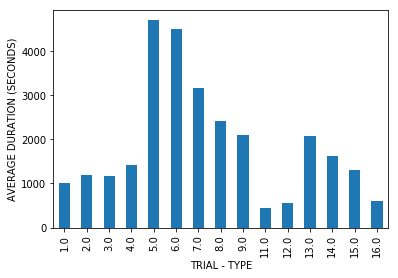

In [9]:
#Plot the average duration of each trial
data_aggregated_trial.iloc[:,0].plot.bar() #all coumns are equal. We will use only the first (0 index) columns
plt.ylabel("AVERAGE DURATION (SECONDS)")
plt.xlabel("TRIAL - TYPE")
plt.show()

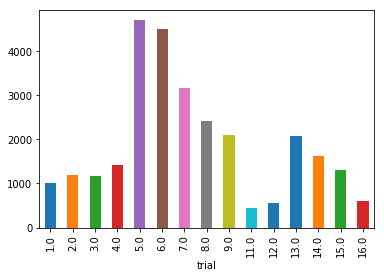

In [20]:
data_aggregated_trial['attitude.roll'].plot.bar()
plt.show()

In [52]:
data['accMagnitude'] = np.sqrt(data['userAcceleration.x']*data['userAcceleration.x'] + data['userAcceleration.y']*data['userAcceleration.y'] +data['userAcceleration.z']*data['userAcceleration.z']) 

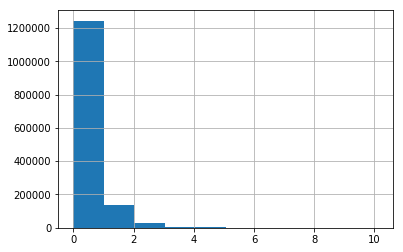

In [53]:
data['accMagnitude'].hist()
plt.show()

### 1.3 TO DOs
- How many participants are females/males? [0:Female, 1:Male]
- Plot the average acceleration magnitude per activity type. What do you notice?

In [48]:
# data_aggregated[data_aggregated.gender==1].count()
#How many participants are females/males? [0:Female, 1:Male]

attitude.roll         14
attitude.pitch        14
attitude.yaw          14
gravity.x             14
gravity.y             14
gravity.z             14
rotationRate.x        14
rotationRate.y        14
rotationRate.z        14
userAcceleration.x    14
userAcceleration.y    14
userAcceleration.z    14
act                   14
weight                14
height                14
age                   14
gender                14
trial                 14
dtype: int64

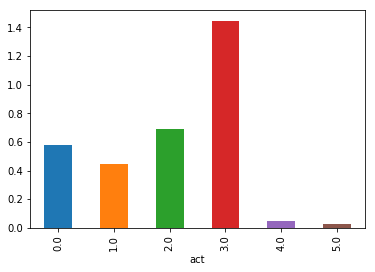

In [54]:
data.groupby('act').mean().accMagnitude.plot.bar()
plt.show()

In [13]:
#your code goes here
#Plot the average acceleration magnitude per activity type. What do you notice?

## 2. Data segmentation (windowing) and filtering

1. Visualize some acceleration data from the first participant (his first trial).
2. Visualize the impact of mean-filtering and low-pass filtering in time domain.
3. Visualize the impact of mean-filtering and low-pass filtering in frequency domain.
4. Create a function for signal segmentation and filtering.

First participant data shape (62312, 20)
First trial of the first participant data shape (1751, 20)


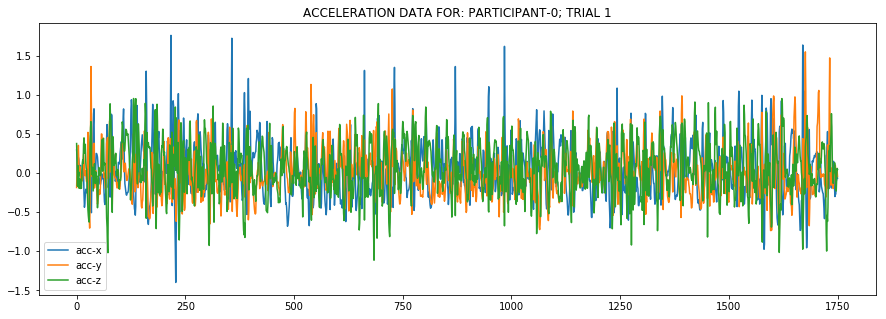

In [14]:
#get the data form the first participant
first_p = data[data.id==0]
print('First participant data shape',first_p.shape)
#get the data form the first trial of the first participant
trial = first_p[first_p.trial==1]
print('First trial of the first participant data shape',trial.shape)

#plot the accelreation data for the first trial
plt.figure(figsize = (15,5))
plt.plot(trial['userAcceleration.x'],label = 'acc-x')
plt.plot(trial['userAcceleration.y'],label = 'acc-y')
plt.plot(trial['userAcceleration.z'],label = 'acc-z')
plt.legend()
plt.title("ACCELERATION DATA FOR: PARTICIPANT-0; TRIAL 1")
plt.show()


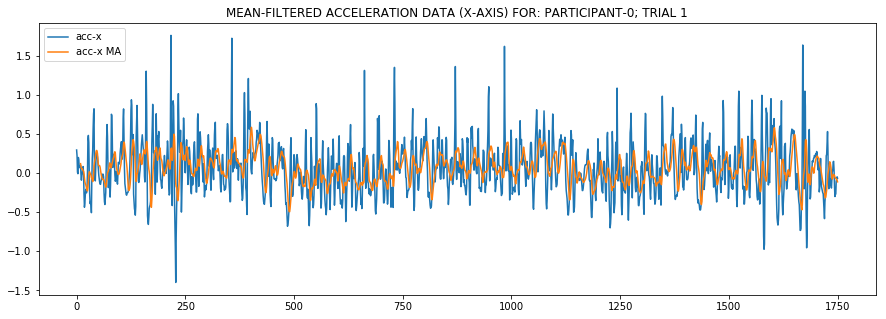

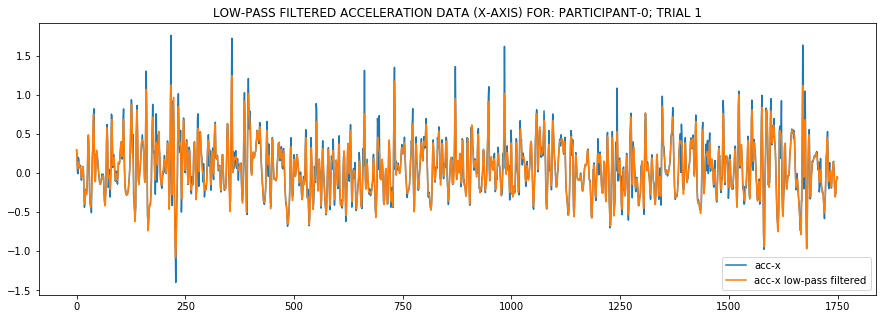

In [15]:
#Visualize the impact of mean-filtering and low-pass filtering in time domain
#plot mean-filtered accelreation data
plt.figure(figsize = (15,5))
plt.plot(trial['userAcceleration.x'],label = 'acc-x')
plt.plot(trial['userAcceleration.x'].rolling(window=10).mean(),label = 'acc-x MA') #moving window with a size of 10 samples
plt.legend()
plt.title("MEAN-FILTERED ACCELERATION DATA (X-AXIS) FOR: PARTICIPANT-0; TRIAL 1")
plt.show()


#plot low-pass filtered accelreation data
plt.figure(figsize = (15,5))
segment = trial['userAcceleration.x'].values
plt.plot(segment,label = 'acc-x')
fs = 50  # Sampling frequency
fc = 10  # Cut-off frequency of the filter
w = fc / (fs / 2) # Normalize the frequency
n= 5 #The order of the filter.
b, a = signal.butter(n, w, 'low')
output = signal.filtfilt(b, a, segment)
plt.plot(output, label='acc-x low-pass filtered')
plt.legend()
plt.title("LOW-PASS FILTERED ACCELERATION DATA (X-AXIS) FOR: PARTICIPANT-0; TRIAL 1")
plt.show()


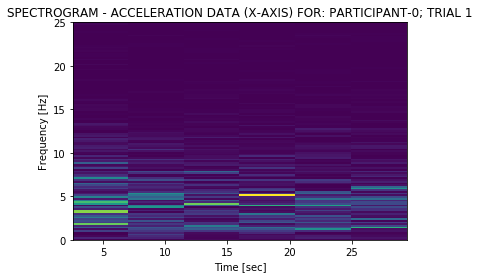

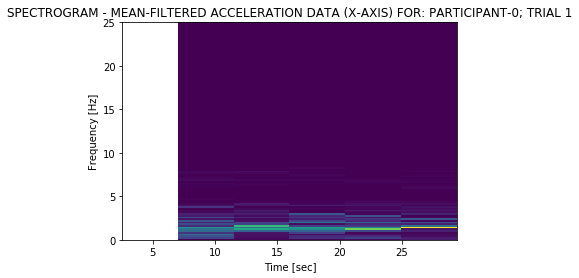

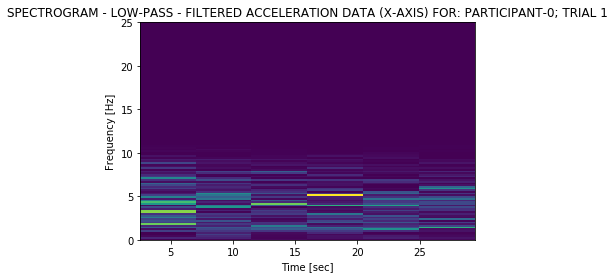

In [16]:
#Visualize the impact of mean-filtering and low-pass filtering in frequency domain
segment = trial['userAcceleration.x'].values
sampling_frequency = 50
frequencies, time, spec = signal.spectrogram(segment, sampling_frequency)
plt.pcolormesh(time, frequencies, spec)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("SPECTROGRAM - ACCELERATION DATA (X-AXIS) FOR: PARTICIPANT-0; TRIAL 1")
plt.show()

segment_mean = trial['userAcceleration.x'].rolling(window=10).mean()
frequencies, time, spec = signal.spectrogram(segment_mean, sampling_frequency)
plt.pcolormesh(time, frequencies, spec)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("SPECTROGRAM - MEAN-FILTERED ACCELERATION DATA (X-AXIS) FOR: PARTICIPANT-0; TRIAL 1")
plt.show()


fs = 50  # Sampling frequency
fc = 10# Cut-off frequency of the filter
w = fc / (fs / 2) # Normalize the frequency
n= 5 #The order of the filter.
b, a = signal.butter(n, w, 'low')
segment_low_pass = signal.filtfilt(b, a, segment)
frequencies, time, spec = signal.spectrogram(segment_low_pass, sampling_frequency)
plt.pcolormesh(time, frequencies, spec)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("SPECTROGRAM - LOW-PASS - FILTERED ACCELERATION DATA (X-AXIS) FOR: PARTICIPANT-0; TRIAL 1")
plt.show()

In [56]:
#Create a function for signal segmentation and filtering.
def low_pass_filter(segment):
    fs = 50  # Sampling frequency
    fc = 5  # Cut-off frequency of the filter
    w = fc / (fs / 2) # Normalize the frequency
    n= 5 #The order of the filter.
    b, a = signal.butter(n, w, 'low')
    output = signal.filtfilt(b, a, segment)
    return output

#the function takes as input a sinal (pandas timeseries) 
#and the size of the window (default 4 seconds)to be used for the segmentation
#the function filters the signal and returns a list of segments
def segment_filter(trial, window_size=4*50):
    trial_f  = low_pass_filter(trial.values) 
    #segment the data
    win_start = 0
    win_end = win_start+window_size
    segments = []
    while win_end<len(trial_f):
        segment = trial_f[win_start:win_end]
        segments.append(segment)
        #move/slide the window
        win_start = win_end - 100
        win_end = win_start+window_size
    
    return segments

#iterate through the data of each participant and each trial and perform segmentation
for participant in data.id.unique():
    data_p = data[data.id==participant]
    print("Segmenting data for participant:", participant)
    print("Participant data shape:", data_p.shape)
    for trial in data_p.trial.unique():
        data_p_t = data_p[data_p.trial==trial]
        print("Trial data shape:", data_p_t.shape)
        for sensor_axis in sensor_columns:
            print("Segmenting sensor-axis:", sensor_axis)
            segment_array = segment_filter(data_p_t[sensor_axis])
            print("Number of segments, segment length:", np.array(segment_array).shape)
        print('-')
    print('---------')

Segmenting data for participant: 0.0
Participant data shape: (62312, 20)
Trial data shape: (1751, 20)
Segmenting sensor-axis: attitude.roll
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
Number of segments, segment length: (16, 200)
Segmenting sensor-axis: attitude.pitch
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
Number of segments, segment length: (16, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
Number of segments, segment length: (16, 200)
Segmenting sensor-axis: gravity.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
Number of segments, segment length: 

1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
Number of segments, segment length: (29, 200)
Segmenting sensor-axis: gravity.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
Number of segments, segment length: (29, 200)
Segmenting sensor-axis: gravity.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
Number of segments, segment length: (29, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 140

Number of segments, segment length: (53, 200)
Segmenting sensor-axis: userAcceleration.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
Number of segments, segment length: (53, 200)
-
Trial data shape: (4340, 20)
Segmenting sensor-axis: attitude.roll
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 320

100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
Number of segments, segment length: (47, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
Num

Number of segments, segment length: (100, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
9000 9200
9100 9300
9200 9400
9300 9500


100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
Number of segments, segment length: (24, 200)
-
Trial data shape: (10292, 20)
Segmenting sensor-axis: attitude.roll
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7

7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
9000 9200
9100 9300
9200 9400
9300 9500
9400 9600
9500 9700
9600 9800
9700 9900
9800 10000
9900 10100
10000 10200
10100 10300
Number of segments, segment length: (101, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500

100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
Number of segments, segment length: (20, 200)
Segmenting sensor-axis: attitude.pitch
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
Number of segments, segment length: (20, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
Number of segments, segment length: (20, 200)
Segmenting sensor-axis: gravity.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
Number of segmen

Number of segments, segment length: (25, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
Number of segments, segment length: (25, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
Number of segments, segment length: (25, 200)
Segmenting sensor-axis: userAcceleration.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
Number of segments, segment len

Number of segments, segment length: (75, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
Number of segments, segment length: (75, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 14

Number of segments, segment length: (55, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
Number of segments, segment length: (55, 200)
Segmenting sensor-axis: userAcceleration.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100

3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
Number of segments, segment length: (48, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
Number of segments, segment length: (48, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 23

6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
Number of segments, segment length: (77, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
Number of s

4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
9000 9200
9100 9300
Number of segments, segment length: (91, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4

200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
Number of segments, segment length: (36, 200)
Segmenting sensor-axis: userAcceleration.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
Number of segments, segment length: (36, 200)
-
---------
Segmenting data for participant: 2.0
Participant data shape: (62553, 20)
Trial data shape: (2270, 20)
Segmenting sensor-axis: attitude.roll
100 300
200 400
300 500
400 600
5

1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
Number of segments, segment length: (22, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
Number of segments, segment length: (22, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
Number of segments, segment length: (22, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
Number of segments, seg

Number of segments, segment length: (63, 200)
Segmenting sensor-axis: gravity.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
Number of segments, segment length: (63, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
25

Number of segments, segment length: (50, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
Number of segments, segment length: (50, 200)
Segmenting sensor-axis: userAcceleration.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600

Number of segments, segment length: (46, 200)
Segmenting sensor-axis: userAcceleration.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
Number of segments, segment length: (46, 200)
-
Trial data shape: (1216, 20)
Segmenting sensor-axis: attitude.roll
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
Number of segments, segment length: (11, 200)
Segmenting sensor-axis: attitude.pitch
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
Number of segments, segment length: (11, 200)
Segmenting sensor-axis: attitude.

8900 9100
9000 9200
9100 9300
9200 9400
9300 9500
9400 9600
9500 9700
9600 9800
9700 9900
9800 10000
9900 10100
10000 10200
10100 10300
Number of segments, segment length: (101, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100


9400 9600
9500 9700
9600 9800
9700 9900
9800 10000
9900 10100
10000 10200
10100 10300
10200 10400
10300 10500
10400 10600
10500 10700
10600 10800
10700 10900
10800 11000
10900 11100
11000 11200
11100 11300
11200 11400
11300 11500
11400 11600
11500 11700
11600 11800
11700 11900
11800 12000
11900 12100
12000 12200
12100 12300
12200 12400
Number of segments, segment length: (122, 200)
Segmenting sensor-axis: gravity.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 62

5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
9000 9200
9100 9300
9200 9400
9300 9500
9400 9600
9500 9700
9600 9800
9700 9900
9800 10000
9900 10100
10000 10200
10100 10300
10200 10400
10300 10500
10400 10600
10500 10700
10600 10800
10700 10900
10800 11000
10900 11100
11000 11200
11100 11300
11200 11400
11300 11500
11400 11600
11500 11700
11600 11800
11700 11900
11800 12000
11900 12100
12000 12200
12100 12300
12200 12400
Number of segments, segment length: (122, 200)
-
Trial data shape: (1894, 20)
Segmenting sensor-axis: attitude.roll
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
Number of segments, segment length: (17, 2

100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
Number of segments, segment length: (8, 200)
Segmenting sensor-axis: gravity.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
Number of segments, segment length: (8, 200)
Segmenting sensor-axis: gravity.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
Number of segments, segment length: (8, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
Number of segments, segment length: (8, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
Number of segments, segment length: (8, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
Number of segments, segment length: (8, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
Number of segments, segment length: (8, 200)
Segmenting 

6000 6200
6100 6300
6200 6400
6300 6500
Number of segments, segment length: (63, 200)
Segmenting sensor-axis: attitude.pitch
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
Number of segments, segment length: (63, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000

2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
Number of segments, segment length: (52, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
Number of segments, segment length: (52, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900

100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
Number of segments, segment length: (51, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 46

4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
Number of segments, segment length: (79, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 62

7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
Number of segments, segment length: (89, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7

1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
Number of segments, segment length: (20, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
Number of segments, segment length: (20, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
Number of segments, segment length: (20, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
Number of segments, segment length: (20, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500


1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
Number of segments, segment length: (25, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
Number of segments, segment length: (25, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
Number of segments, segment length: (25, 200)
Segmenting sensor-axis: userAcceleration.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1

Number of segments, segment length: (37, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
Number of segments, segment length: (37, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
Number of segments, segment length: (37, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
300 500
400 6

800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
9000 9200
9100 9300
Number of segments, segment length: (91, 200)
Segmenting sensor-axis: attitude.pitch
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
100

Number of segments, segment length: (31, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
Number of segments, segment length: (31, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
Number of segments, segment length: (31, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 200

7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
9000 9200
9100 9300
9200 9400
9300 9500
9400 9600
9500 9700
Number of segments, segment length: (95, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 73

Number of segments, segment length: (20, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
Number of segments, segment length: (20, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
Number of segments, segment length: (20, 200)
Segmenting sensor-axis: userAcceleration.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
Number of segments, segment length: (20, 200)
-
Trial data shape: (2484, 20)
Segmenting sensor-axis: attitude.roll
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
9

100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
Number of segments, segment length: (23, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
Number of segments, segment length: (23, 200)
Segmenting sensor-axis: userAcceleration.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
Number of segments, segment length: (23, 200)
-
Trial data shape: (1026, 20)
Segmenting sensor-axis: attitude.roll
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000


6800 7000
6900 7100
Number of segments, segment length: (69, 200)
-
Trial data shape: (5176, 20)
Segmenting sensor-axis: attitude.roll
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
Number of segments, segment length: (50, 200)
Segmenting sensor-axis: attitude.pitch
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
32

Number of segments, segment length: (42, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
Number of segments, segment length: (42, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
Number of segments, se

1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
Number of segments, segment length: (86, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2

1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
Number of segments, segment length: (76, 200)
Segmenting sensor-axis: attitude.pitch
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3

Number of segments, segment length: (39, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
Number of segments, segment length: (39, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
Number of segments, segment length: (39, 200)
Segmenting sensor-axis: rotationRate.y
10

Number of segments, segment length: (8, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
Number of segments, segment length: (8, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
Number of segments, segment length: (8, 200)
Segmenting sensor-axis: userAcceleration.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
Number of segments, segment length: (8, 200)
-
Trial data shape: (2787, 20)
Segmenting sensor-axis: attitude.roll
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
Number of segments, segment length: (26, 200)
Segmenting sensor-axis: attitude.pitch
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200

Number of segments, segment length: (12, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
Number of segments, segment length: (12, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
Number of segments, segment length: (12, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
Number of segments, segment length: (12, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
Number of segments, segment length: (12, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
Number of segments, segment length: (12, 200)
S

4500 4700
4600 4800
4700 4900
Number of segments, segment length: (47, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
Number of segments, segment length: (47, 200)
Segmenting sensor-axis: gravity.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900

4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
Number of segments, segment length: (44, 200)
Segmenting sensor-axis: gravity.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
Number of segments, segment length: (44, 200)
Segmenting sensor-axis: gravity.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
39

8800 9000
8900 9100
9000 9200
9100 9300
Number of segments, segment length: (91, 200)
Segmenting sensor-axis: gravity.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
9000 9

1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
Number of segments, segment length: (25, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
Number of segments, segment length: (25, 200)
Segmenting sensor-axis: userAcceleration.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
Number of segments, segment length: (25, 200)
-
Trial data shape: (11383, 20)
Segmenting sensor-axis: attitude.roll
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200

6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
9000 9200
9100 9300
9200 9400
9300 9500
9400 9600
9500 9700
9600 9800
9700 9900
9800 10000
9900 10100
10000 10200
10100 10300
10200 10400
10300 10500
10400 10600
10500 10700
10600 10800
10700 10900
10800 11000
10900 11100
11000 11200
11100 11300
11200 11400
Number of segments, segment length: (112, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 460

Number of segments, segment length: (20, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
Number of segments, segment length: (20, 200)
Segmenting sensor-axis: userAcceleration.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
Number of segments, segment length: (20, 200)
-
Trial data shape: (2448, 20)
Segmenting sensor-axis: attitude.roll
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
Number of segments, segment length: (23, 200)
Segmenting sensor-axis: attitude.pitch
100 300
200 400
300 500
400 600
500 700


2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
Number of segments, segment length: (28, 200)
Segmenting sensor-axis: gravity.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
Number of segments, segment length: (28, 200)
Segmenting sensor-axis: gravity.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
Number of segments, segment length: (28, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 200

5700 5900
5800 6000
5900 6100
6000 6200
Number of segments, segment length: (60, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
Number of segments, segment length: (60, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200

Number of segments, segment length: (25, 200)
Segmenting sensor-axis: userAcceleration.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
Number of segments, segment length: (25, 200)
-
Trial data shape: (4247, 20)
Segmenting sensor-axis: attitude.roll
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
Number of segments, segment length: (41, 200)
Segmenting sensor-axis: attitude.pitch
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200

5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
9000 9200
9100 9300
9200 9400
9300 9500
9400 9600
9500 9700
9600 9800
9700 9900
9800 10000
9900 10100
10000 10200
10100 10300
10200 10400
10300 10500
10400 10600
Number of segments, segment length: (104, 200)
Segmenting sensor-axis: gravity.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
420

3000 3200
Number of segments, segment length: (30, 200)
Segmenting sensor-axis: gravity.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
Number of segments, segment length: (30, 200)
Segmenting sensor-axis: gravity.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
Number of segments, segment length: (30, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 220

5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
9000 9200
9100 9300
9200 9400
9300 9500
9400 9600
9500 9700
Number of segments, segment length: (95, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5

100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
Number of segments, segment length: (19, 200)
Segmenting sensor-axis: gravity.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
Number of segments, segment length: (19, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
Number of segments, segment length: (19, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
Number of segments, segment length: (19, 200)
Segmenting se

Number of segments, segment length: (27, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
Number of segments, segment length: (27, 200)
Segmenting sensor-axis: gravity.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
Number of segments, segment length: (27, 200)
Segmenting sensor-axis: gravity.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 

Number of segments, segment length: (70, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
Number of segments, segment length: (70, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 180

1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
Number of segments, segment length: (22, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
Number of segments, segment length: (22, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
Number of segments, segment length: (22, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
Number of segments, segment length: (22, 200)
Seg

2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
Number of segments, segment length: (75, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4

10800 11000
10900 11100
11000 11200
Number of segments, segment length: (110, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
9000 9

Number of segments, segment length: (49, 200)
Segmenting sensor-axis: attitude.pitch
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
Number of segments, segment length: (49, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800

Number of segments, segment length: (27, 200)
Segmenting sensor-axis: gravity.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
Number of segments, segment length: (27, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
Number of segments, segment length: (27, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
270

Number of segments, segment length: (28, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
Number of segments, segment length: (28, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
Number of segments, segment length: (28, 200)
Segmenting sensor-axis: userAcceleration.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2

800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
Number of segments, segment length: (60, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 

Number of segments, segment length: (42, 200)
Segmenting sensor-axis: attitude.pitch
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
Number of segments, segment length: (42, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
Number of segments, segm

Number of segments, segment length: (70, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
Number of segments, segment length: (70, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 19

5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
9000 9200
9100 9300
9200 9400
Number of segments, segment length: (92, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
560

Number of segments, segment length: (57, 200)
Segmenting sensor-axis: gravity.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
Number of segments, segment length: (57, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
31

1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
Number of segments, segment length: (26, 200)
Segmenting sensor-axis: userAcceleration.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
Number of segments, segment length: (26, 200)
-
Trial data shape: (969, 20)
Segmenting sensor-axis: attitude.roll
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
Number of segments, segment length: (8, 200)
Segmenting sensor-axis: attitude.pitch
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
Number of segments, segment length: (8, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
Number of segments, segment length: (8, 200)
Segmenting sensor-axis: gravity.x
100

100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
Number of segments, segment length: (65, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200

Number of segments, segment length: (47, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
Number of segments, segment length: (47, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900

6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
9000 9200
9100 9300
9200 9400
9300 9500
9400 9600
9500 9700
9600 9800
9700 9900
9800 10000
9900 10100
10000 10200
10100 10300
10200 10400
10300 10500
10400 10600
10500 10700
10600 10800
10700 10900
10800 11000
10900 11100
11000 11200
11100 11300
Number of segments, segment length: (111, 200)
Segmenting sensor-axis: attitude.pitch
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700

4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
9000 9200
9100 9300
9200 9400
9300 9500
9400 9600
9500 9700
9600 9800
9700 9900
9800 10000
9900 10100
10000 10200
10100 10300
10200 10400
10300 10500
10400 10600
10500 10700
10600 10800
10700 10900
10800 11000
10900 11100
11000 11200
11100 11300
Number of segments, segment length: (111, 200)
Segmenting sensor-axis: userAcceleration.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400


Number of segments, segment length: (78, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
Number of segments, segment length: (78, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 10

Number of segments, segment length: (75, 200)
-
---------
Segmenting data for participant: 11.0
Participant data shape: (53293, 20)
Trial data shape: (1522, 20)
Segmenting sensor-axis: attitude.roll
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
Number of segments, segment length: (14, 200)
Segmenting sensor-axis: attitude.pitch
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
Number of segments, segment length: (14, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
Number of segments, segment length: (14, 200)
Segmenting sensor-axis: gravity.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
Number of segments, segment length: (14, 200)
Segmenting 

Number of segments, segment length: (27, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
Number of segments, segment length: (27, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
Number of segments, segment length: (27, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 280

5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
Number of segments, segment length: (66, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
Number of segments, segment length: (66, 200)
Segmenting sensor-axis: userAcceleration.z
100 300
200 400
30

100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
Number of segments, segment length: (44, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
Number of segments, segment length: (44, 200)
Segmenting sensor-axis:

800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
9000 9200
9100 9300
9200 9400
Number of segments, segment length: (92, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
90

5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
Number of segments, segment length: (79, 200)
Segmenting sensor-axis: gravity.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7

Number of segments, segment length: (14, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
Number of segments, segment length: (14, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
Number of segments, segment length: (14, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
Number of segments, segment length: (14, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
Number of segments, segment length: (14, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1

Number of segments, segment length: (53, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
Number of segments, segment length: (53, 200)
Segmenting sensor-axis: gravity.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600

100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
Number of segments, segment length: (16, 200)
Segmenting sensor-axis: gravity.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
Number of segments, segment length: (16, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
Number of segments, segment length: (16, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
Number of segments, segment length: (16, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300


Number of segments, segment length: (117, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
9000 9200
9100 9300
9200 9400
9300 9500
94

Number of segments, segment length: (37, 200)
Segmenting sensor-axis: attitude.pitch
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
Number of segments, segment length: (37, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
Number of segments, segment length: (37, 200)
Segmenting sensor-axis: gravity.x
100 300
200 400
300 500
400 600
500 700
600 

5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
9000 9200
9100 9300
9200 9400
9300 9500
9400 9600
9500 9700
9600 9800
9700 9900
9800 10000
Number of segments, segment length: (98, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000


1500 1700
1600 1800
Number of segments, segment length: (16, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
Number of segments, segment length: (16, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
Number of segments, segment length: (16, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
Number of segments, segment length: (16, 200)
Segmenting sensor-axis: userAcceleration.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
Number of segments, segment length: (16, 200)
-
Tria

Number of segments, segment length: (9, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
Number of segments, segment length: (9, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
Number of segments, segment length: (9, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
Number of segments, segment length: (9, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
Number of segments, segment length: (9, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
Number of segments, segment length: (9, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
Number of segments, segment length: (9, 200)
Segm

4400 4600
4500 4700
Number of segments, segment length: (45, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
Number of segments, segment length: (45, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
40

1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
Number of segments, segment length: (37, 200)
-
Trial data shape: (1237, 20)
Segmenting sensor-axis: attitude.roll
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
Number of segments, segment length: (11, 200)
Segmenting sensor-axis: attitude.pitch
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
Number of segments, segment length: (11, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
Number of segments, segment length: (11, 200)
Segmenting sensor-axis: gravity.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
N

Number of segments, segment length: (97, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
9000 9200
9100 9300
9200 9400
9300 95

3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
9000 9200
9100 9300
9200 9400
9300 9500
9400 9600
9500 9700
9600 9800
9700 9900
9800 10000
9900 10100
10000 10200
10100 10300
10200 10400
10300 10500
10400 10600
10500 10700
10600 10800
10700 10900
10800 11000
10900 11100
11000 11200
11100 11300
11200 11400
11300 11500
11400 11600
11500 11700
11600 11800
11700 11900
11800 12000
11900 12100
12000 12200
12100 12300
12200 12400
12300 12500
12400 12600
12500 12700
12600 12800
Number of segments, segment length: (126, 20

100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
Number of segments, segment length: (28, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
Number of segments, segment length: (28, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
Number of segments, segment length: (28, 20

Number of segments, segment length: (23, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
Number of segments, segment length: (23, 200)
Segmenting sensor-axis: gravity.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
Number of segments, segment length: (23, 200)
Segmenting sensor-axis: gravity.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
Number of segments, segment length: (23, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500

5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
Number of segments, segment length: (68, 200)
Segmenting sensor-axis: gravity.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
Number of segments, segment length: (68, 200)
Segmenting sensor-axis: gravity.y
100 300
200 400
300 500
400 600
500 

Number of segments, segment length: (48, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
Number of segments, segment length: (48, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 400

3800 4000
Number of segments, segment length: (38, 200)
Segmenting sensor-axis: userAcceleration.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
Number of segments, segment length: (38, 200)
-
Trial data shape: (1178, 20)
Segmenting sensor-axis: attitude.roll
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
Number of segments, segment length: (10, 200)
Segmenting sensor-axis: attitude.pitch
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
Number of segments, segment length: (10, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
Nu

400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
Number of segments, segment length: (75, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 24

7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
9000 9200
9100 9300
9200 9400
9300 9500
9400 9600
9500 9700
9600 9800
9700 9900
Number of segments, segment length: (97, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7

Number of segments, segment length: (58, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
Number of segments, segment length: (58, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 300

Number of segments, segment length: (11, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
Number of segments, segment length: (11, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
Number of segments, segment length: (11, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
Number of segments, segment length: (11, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
Number of segments, segment length: (11, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
Number of segments, segment length: (11, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
3

1100 1300
1200 1400
1300 1500
Number of segments, segment length: (13, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
Number of segments, segment length: (13, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
Number of segments, segment length: (13, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
Number of segments, segment length: (13, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
Number of segments, segment length: (13, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1

4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
Number of segments, segment length: (53, 200)
Segmenting sensor-axis: attitude.pitch
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
Number of segments, segment length: (53, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000

Number of segments, segment length: (47, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
Number of segments, segment length: (47, 200)
Segmenting sensor-axis: gravity.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200

Number of segments, segment length: (91, 200)
Segmenting sensor-axis: gravity.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
9000 9200
9100 9300
Number of segments, segmen

1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
Number of segments, segment length: (41, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
Number of segments, segment length: (41, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500

6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
9000 9200
9100 9300
9200 9400
9300 9500
9400 9600
9500 9700
9600 9800
9700 9900
9800 10000
9900 10100
10000 10200
10100 10300
10200 10400
10300 10500
10400 10600
10500 10700
10600 10800
10700 10900
10800 11000
10900 11100
Number of segments, segment length: (109, 200)
Segmenting sensor-axis: userAcceleration.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200

500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
Number of segments, segment length: (28, 200)
Segmenting sensor-axis: gravity.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
Number of segments, segment length: (28, 200)
Segmenting sensor-axis: gravity.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
Number of segments, segment length: (28, 200)
Segmenting sensor-axis: gravity.z


2500 2700
2600 2800
2700 2900
2800 3000
Number of segments, segment length: (28, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
Number of segments, segment length: (28, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
Number of segments, segment length: (28, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 220

Number of segments, segment length: (68, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
Number of segments, segment length: (68, 200)
Segmenting sensor-axis: userAcceleration.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800

100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
Number of segments, segment length: (32, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
Number of segments, segment length: (32, 200)
Segmenting sensor-axis: gravity.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 

5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
Number of segments, segment length: (69, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
Number of segments, segment length: (69, 200)
Segmenting sensor-axis: u

8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
9000 9200
9100 9300
9200 9400
9300 9500
9400 9600
9500 9700
9600 9800
9700 9900
9800 10000
9900 10100
10000 10200
10100 10300
10200 10400
10300 10500
10400 10600
10500 10700
10600 10800
10700 10900
10800 11000
10900 11100
11000 11200
11100 11300
Number of segments, segment length: (111, 200)
Segmenting sensor-axis: gravity.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600

Number of segments, segment length: (30, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
Number of segments, segment length: (30, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
Number of segments, segment length: (30, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 220

100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
Number of segments, segment length: (10, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
Number of segments, segment length: (10, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
Number of segments, segment length: (10, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
Number of segments, segment length: (10, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
Number of segments, segment length: (10, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
Number of segments, segment length: (10, 200)
Segmenting sensor-axis: us

Number of segments, segment length: (83, 200)
Segmenting sensor-axis: attitude.pitch
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
Number of segments, segment length: (83, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
30

1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
Number of segments, segment length: (58, 200)
Segmenting sensor-axis: gravity.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5

1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
Number of segments, segment length: (47, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
Number of segments, segment length: (47, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 

Number of segments, segment length: (74, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
Number of segments, segment length: (74, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200

Number of segments, segment length: (88, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
8700 8900
8800 9000
Number of segments, segment length: (88, 200)
Segmenting

100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
Number of segments, segment length: (43, 200)
-
---------
Segmenting data for participant: 18.0
Participant data shape: (71949, 20)
Trial data shape: (2048, 20)
Segmenting sensor-axis: attitude.roll
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
Number of segments, segment length: (19, 200)
Segmenting sensor-axis: attitude.pitch
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500

100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
Number of segments, segment length: (28, 200)
Segmenting sensor-axis: userAcceleration.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
Number of segments, segment length: (28, 200)
-
Trial data shape: (3529, 20)
Segmenting sensor-axis: attitude.roll
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900

5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
Number of segments, segment length: (65, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
Number of segments, segment length: (65, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
9

Number of segments, segment length: (31, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
Number of segments, segment length: (31, 200)
Segmenting sensor-axis: gravity.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
Number of segments, segment length: (31, 200)
Segmenting sensor-axis: gravity.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 

Number of segments, segment length: (11, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
Number of segments, segment length: (11, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
Number of segments, segment length: (11, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
Number of segments, segment length: (11, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
Number of segments, segment length: (11, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
Number of segments, segment length: (11, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
3

Number of segments, segment length: (163, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
9000 9200
9100 9300
9200 9400
9300 9500


3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
Number of segments, segment length: (39, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
Number of segments, segment length: (39, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
Number of segments, segment

2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
9000 9200
9100 9300
9200 9400
9300 9500
9400 9600
9500 9700
9600 9800
9700 9900
9800 10000
9900 10100
10000 10200
10100 10300
10200 10400
10300 10500
10400 10600
10500 10700
10600 10800
10700 10900
10800 11000
10900 11100
11000 11200
11100 11300
11200 11400
11300 11500
11400 11600
11500 11700
Number of segments, segment length: 

Number of segments, segment length: (48, 200)
-
---------
Segmenting data for participant: 19.0
Participant data shape: (55153, 20)
Trial data shape: (2236, 20)
Segmenting sensor-axis: attitude.roll
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
Number of segments, segment length: (21, 200)
Segmenting sensor-axis: attitude.pitch
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
Number of segments, segment length: (21, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
Number of segments, segment length: (21, 200)
Segme

Number of segments, segment length: (24, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
Number of segments, segment length: (24, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
Number of segments, segment length: (24, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
Number of segments, segment length: (24, 200)
Segmenting sensor-axis:

200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
Number of segments, segment length: (69, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 29

Number of segments, segment length: (49, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
Number of segments, segment length: (49, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
38

1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
Number of segments, segment length: (40, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
Number of segments, segment length: (40, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
17

6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
9000 9200
9100 9300
9200 9400
9300 9500
9400 9600
9500 9700
Number of segments, segment length: (95, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6

7600 7800
7700 7900
7800 8000
Number of segments, segment length: (78, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
Number of segments, segment length: (78, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 

Number of segments, segment length: (28, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
Number of segments, segment length: (28, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
Number of segments, segment length: (28, 200)
Segmenting sensor-axis: userAcceleration.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2

2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
Number of segments, segment length: (32, 200)
Segmenting sensor-axis: userAcceleration.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
Number of segments, segment length: (32, 200)
-
Trial data shape: (3702, 20)
Segmenting sensor-axis: attitude.roll
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
Number of segments, segment length: (3

2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
Number of segments, segment length: (72, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4

500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
Number of segments, segment length: (62, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 

1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
Number of segments, segment length: (54, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
Number of segments, segment

8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
9000 9200
9100 9300
9200 9400
9300 9500
9400 9600
9500 9700
9600 9800
9700 9900
9800 10000
9900 10100
10000 10200
10100 10300
10200 10400
10300 10500
Number of segments, segment length: (103, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100


Number of segments, segment length: (102, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
8400 8600
8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
9000 9200
9100 9300
9200 9400
9300 9500
94

100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
Number of segments, segment length: (40, 200)
Segmenting sensor-axis: attitude.pitch
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
Number of segments, segment length: (40, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000

100 300
200 400
300 500
400 600
500 700
Number of segments, segment length: (5, 200)
Segmenting sensor-axis: gravity.x
100 300
200 400
300 500
400 600
500 700
Number of segments, segment length: (5, 200)
Segmenting sensor-axis: gravity.y
100 300
200 400
300 500
400 600
500 700
Number of segments, segment length: (5, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
Number of segments, segment length: (5, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
Number of segments, segment length: (5, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
Number of segments, segment length: (5, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
Number of segments, segment length: (5, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
Number of segments, segment length: (5, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400

5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
Number of segments, segment length: (63, 200)
Segmenting sensor-axis: gravity.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
Number of segments, segment length: (63, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
17

Number of segments, segment length: (48, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
Number of segments, segment length: (48, 200)
Segmenting sensor-axis: userAcceleration.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800

Number of segments, segment length: (13, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
Number of segments, segment length: (13, 200)
Segmenting sensor-axis: gravity.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
Number of segments, segment length: (13, 200)
Segmenting sensor-axis: gravity.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
Number of segments, segment length: (13, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
Number of segments, segment length: (13, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
Number of segments, se

1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
Number of segments, segment length: (56, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
470

2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7500
7400 7600
7500 7700
7600 7800
7700 7900
7800 8000
7900 8100
8000 8200
8100 8300
8200 8400
8300 8500
Number of segments, segment length: (83, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3

Number of segments, segment length: (22, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
Number of segments, segment length: (22, 200)
Segmenting sensor-axis: gravity.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
Number of segments, segment length: (22, 200)
Segmenting sensor-axis: gravity.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
Number of segments, segment length: (22, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000


Number of segments, segment length: (31, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
Number of segments, segment length: (31, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
Number of segments, segment length: (31, 200)
Segmenting sensor-axis: userAcceleration.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1

Number of segments, segment length: (64, 200)
Segmenting sensor-axis: gravity.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
Number of segments, segment length: (64, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
24

5200 5400
5300 5500
Number of segments, segment length: (53, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
Number of segments, segment length: (53, 200)
Segmenting sensor-axis: userAcceleration.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100

1000 1200
Number of segments, segment length: (10, 200)
Segmenting sensor-axis: gravity.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
Number of segments, segment length: (10, 200)
Segmenting sensor-axis: gravity.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
Number of segments, segment length: (10, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
Number of segments, segment length: (10, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
Number of segments, segment length: (10, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
Number of segments, segment length: (10, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
9

600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
Number of segments, segment length: (20, 200)
Segmenting sensor-axis: attitude.yaw
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
Number of segments, segment length: (20, 200)
Segmenting sensor-axis: gravity.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
Number of segments, segment length: (20, 200)
Segmenting sensor-axis: gravity.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
Number of segments, segment length: (20, 200)
Segmenting sens

Number of segments, segment length: (29, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
Number of segments, segment length: (29, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
Number of segments, segment length: (29, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
220

Number of segments, segment length: (14, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
Number of segments, segment length: (14, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
Number of segments, segment length: (14, 200)
Segmenting sensor-axis: rotationRate.z
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
Number of segments, segment length: (14, 200)
Segmenting sensor-axis: userAcceleration.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
Number of segments, segment length: (14, 200)
Segmenting sensor-axis: userAcceleration.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 11

1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
Number of segments, segment length: (39, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
Number of segments, segment length: (39, 200)
Segmenting sensor-axis: rotationRate.y
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
23

8500 8700
8600 8800
8700 8900
8800 9000
8900 9100
9000 9200
9100 9300
9200 9400
9300 9500
9400 9600
9500 9700
9600 9800
9700 9900
9800 10000
9900 10100
10000 10200
10100 10300
10200 10400
10300 10500
10400 10600
10500 10700
10600 10800
10700 10900
10800 11000
Number of segments, segment length: (108, 200)
Segmenting sensor-axis: attitude.pitch
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900


Number of segments, segment length: (108, 200)
-
Trial data shape: (3969, 20)
Segmenting sensor-axis: attitude.roll
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
Number of segments, segment length: (38, 200)
Segmenting sensor-axis: attitude.pitch
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
Number of segments, segment length: (38, 200)
Segmenting sensor-axis: a

8700 8900
8800 9000
8900 9100
9000 9200
9100 9300
9200 9400
9300 9500
9400 9600
9500 9700
9600 9800
9700 9900
9800 10000
9900 10100
10000 10200
10100 10300
10200 10400
10300 10500
10400 10600
10500 10700
Number of segments, segment length: (105, 200)
Segmenting sensor-axis: rotationRate.x
100 300
200 400
300 500
400 600
500 700
600 800
700 900
800 1000
900 1100
1000 1200
1100 1300
1200 1400
1300 1500
1400 1600
1500 1700
1600 1800
1700 1900
1800 2000
1900 2100
2000 2200
2100 2300
2200 2400
2300 2500
2400 2600
2500 2700
2600 2800
2700 2900
2800 3000
2900 3100
3000 3200
3100 3300
3200 3400
3300 3500
3400 3600
3500 3700
3600 3800
3700 3900
3800 4000
3900 4100
4000 4200
4100 4300
4200 4400
4300 4500
4400 4600
4500 4700
4600 4800
4700 4900
4800 5000
4900 5100
5000 5200
5100 5300
5200 5400
5300 5500
5400 5600
5500 5700
5600 5800
5700 5900
5800 6000
5900 6100
6000 6200
6100 6300
6200 6400
6300 6500
6400 6600
6500 6700
6600 6800
6700 6900
6800 7000
6900 7100
7000 7200
7100 7300
7200 7400
7300 7

### 2.2 TO DOs
- Using the same code for spectrogram visualization, visualize the impact of the low-pass filtering for a cut-off frequency of 1 and 10 Hz.
- Update the function "segment_filter" so that it segments the singal with a 50% overlap.

In [18]:
#your code goes here
#Visualize the impact of the low-pass filtering 


In [19]:
#your code goes here
#Update the function "segment_filter" so that it segments the singal with a 50% overlap.

### Further reading
- Pandas as time-series: https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
- Data visualization: https://elitedatascience.com/python-seaborn-tutorial
- Filtering: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.butter.html
- Spectrogram: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html
-  More info about the dataset and analysis performed over it:
http://doi.acm.org/10.1145/3302505.3310068 (Malekzadeh et al. "Mobile sensor data anonymization", Proceedings of the International Conference on Internet of Things Design and Implementation, 2019).